<a href="https://colab.research.google.com/github/Boonyaratt/Two-Tower-Recommendation/blob/master/100Promotion_LGBMRanker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1.Import Library & Datasets

In [1]:
# Import required libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings
from datetime import datetime, timedelta
from dateutil import easter
from typing import Dict, Text
import os, kagglehub
import lightgbm as lgb
import heapq
from functools import lru_cache
from collections import defaultdict
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)

print("Pandas version:", pd.__version__)
print("NumPy version:", np.__version__)

Pandas version: 2.2.2
NumPy version: 2.0.2


In [2]:
!mkdir Dataset

# Datasets

## 2.Display Dataset Information

In [3]:
import os, pathlib
os.environ["KAGGLEHUB_CACHE"] = "/content/Dataset"  # exact case
pathlib.Path("/content/Dataset").mkdir(parents=True, exist_ok=True)

import kagglehub
kaggle_path = kagglehub.dataset_download("frtgnn/dunnhumby-the-complete-journey")
print(kaggle_path)

100%|██████████| 124M/124M [00:00<00:00, 266MB/s]

Extracting files...


/content/Dataset/datasets/frtgnn/dunnhumby-the-complete-journey/versions/1


In [5]:
# Read all CSV files

# path = "/kaggle/input/dunnhumby-the-complete-journey/"
path = "/content/Dataset/datasets/frtgnn/dunnhumby-the-complete-journey/versions/1/"

campaign_desc = pd.read_csv(path + "campaign_desc.csv")
campaign_table = pd.read_csv(path + "campaign_table.csv")
coupon_redempt = pd.read_csv(path + "coupon_redempt.csv") ## 1 counpon_unc can have multiple product_id: 556 nunique from 2318
coupon = pd.read_csv(path + "coupon.csv")
product = pd.read_csv(path + "product.csv")
transaction_data = pd.read_csv(path + "transaction_data.csv")
# Check the dataframes
print("DataFrames loaded successfully!")
print(f"campaign_desc shape: {campaign_desc.shape}")
print(f"campaign_table shape: {campaign_table.shape}")
print(f"coupon_redempt shape: {coupon_redempt.shape}")
print(f"coupon shape: {coupon.shape}")
print(f"product shape: {product.shape}")
print(f"transaction_data shape: {transaction_data.shape}")

# Show headers for each dataset
print("Headers for each dataset:")
print("=" * 50)

datasets = {
    'campaign_desc': campaign_desc,
    'campaign_table': campaign_table,
    'coupon_redempt': coupon_redempt,
    'coupon': coupon,
    'product': product,
    'transaction_data': transaction_data
}

for name, df in datasets.items():
    print(f"\n{name}:")
    print(f"Columns: {list(df.columns)}")



DataFrames loaded successfully!
campaign_desc shape: (30, 4)
campaign_table shape: (7208, 3)
coupon_redempt shape: (2318, 4)
coupon shape: (124548, 3)
product shape: (92353, 7)
transaction_data shape: (2595732, 12)
Headers for each dataset:

campaign_desc:
Columns: ['DESCRIPTION', 'CAMPAIGN', 'START_DAY', 'END_DAY']

campaign_table:
Columns: ['DESCRIPTION', 'household_key', 'CAMPAIGN']

coupon_redempt:
Columns: ['household_key', 'DAY', 'COUPON_UPC', 'CAMPAIGN']

coupon:
Columns: ['COUPON_UPC', 'PRODUCT_ID', 'CAMPAIGN']

product:
Columns: ['PRODUCT_ID', 'MANUFACTURER', 'DEPARTMENT', 'BRAND', 'COMMODITY_DESC', 'SUB_COMMODITY_DESC', 'CURR_SIZE_OF_PRODUCT']

transaction_data:
Columns: ['household_key', 'BASKET_ID', 'DAY', 'PRODUCT_ID', 'QUANTITY', 'SALES_VALUE', 'STORE_ID', 'RETAIL_DISC', 'TRANS_TIME', 'WEEK_NO', 'COUPON_DISC', 'COUPON_MATCH_DISC']


In [ ]:
product.info()

###2-1. Sample Selection

####Houeholds Key Selection

In [6]:
# keep top-N households by txn count (สำหรับเทสต์)
N_HH = 500
top_hh = (transaction_data["household_key"].value_counts().head(N_HH).index.astype(str))
transaction_data = transaction_data[transaction_data["household_key"].astype(str).isin(top_hh)].copy()
campaign_table   = campaign_table[campaign_table["household_key"].astype(str).isin(set(top_hh))].copy()
coupon_redempt   = coupon_redempt[coupon_redempt["household_key"].astype(str).isin(set(top_hh))].copy()

#### Window day Selection

In [7]:
# === OPTIONAL: Dataset windowing to speed up ===
# ใช้ช่วงวันล่าสุด N วัน (เช่น 180 วันล่าสุด) หรือกำหนดช่วงเองก็ได้
WINDOW_DAYS = 180

min_day_all = int(transaction_data["DAY"].min())
max_day_all = int(transaction_data["DAY"].max())
start_day = max(min_day_all, max_day_all - WINDOW_DAYS + 1)
end_day   = max_day_all

# 1) ตัดธุรกรรมให้เหลือเฉพาะช่วงวัน
transaction_data = transaction_data[(transaction_data["DAY"] >= start_day) & (transaction_data["DAY"] <= end_day)].copy()

# 2) จำกัด household ให้เหลือเฉพาะที่ยังมีธุรกรรมในช่วงวัน
keep_hh = set(transaction_data["household_key"].astype(str).unique())
campaign_table = campaign_table[campaign_table["household_key"].astype(str).isin(keep_hh)].copy()
coupon_redempt = coupon_redempt[coupon_redempt["household_key"].astype(str).isin(keep_hh)].copy()

# 3) จำกัดแคมเปญให้ทับซ้อนช่วงวัน (START_DAY..END_DAY) กับหน้าต่างที่เลือก
campaign_desc = campaign_desc[
    (campaign_desc["END_DAY"] >= start_day) & (campaign_desc["START_DAY"] <= end_day)
].copy()
keep_campaigns = set(campaign_desc["CAMPAIGN"].astype(str).unique())
campaign_table = campaign_table[campaign_table["CAMPAIGN"].astype(str).isin(keep_campaigns)].copy()
coupon_redempt = coupon_redempt[coupon_redempt["CAMPAIGN"].astype(str).isin(keep_campaigns)].copy()
coupon = coupon[coupon["CAMPAIGN"].astype(str).isin(keep_campaigns)].copy()

# 4) (ออปชัน) จำกัดสินค้าให้เหลือเฉพาะที่ปรากฏในธุรกรรมช่วงนี้ เพื่อยุบมิติ OHE
keep_products = set(transaction_data["PRODUCT_ID"].astype(str).unique())
product = product[product["PRODUCT_ID"].astype(str).isin(keep_products)].copy()

print(f"Using DAY window [{start_day}, {end_day}]")
print("transaction_data:", transaction_data.shape, "campaign_desc:", campaign_desc.shape,
      "campaign_table:", campaign_table.shape, "coupon_redempt:", coupon_redempt.shape,
      "coupon:", coupon.shape, "product:", product.shape)

Using DAY window [532, 711]
transaction_data: (367796, 12) campaign_desc: (13, 4) campaign_table: (2168, 3) coupon_redempt: (1177, 4) coupon: (87484, 3) product: (36206, 7)


In [8]:
transaction_data['household_key'] = transaction_data['household_key'].astype(str)
transaction_data['STORE_ID'] = transaction_data['STORE_ID'].astype(str)
transaction_data['PRODUCT_ID'] = transaction_data['PRODUCT_ID'].astype(str)
transaction_data['BASKET_ID'] = transaction_data['BASKET_ID'].astype(str)

# FIXED: Use .astype(str) instead of str() for the entire column
coupon['COUPON_UPC'] = coupon['COUPON_UPC'].astype(str)  # Changed this line
coupon['PRODUCT_ID'] = coupon['PRODUCT_ID'].astype(str)
coupon['CAMPAIGN'] = coupon['CAMPAIGN'].astype(str)

campaign_desc['CAMPAIGN'] = campaign_desc['CAMPAIGN'].astype(str)

coupon_redempt['household_key'] = coupon_redempt['household_key'].astype(str)
coupon_redempt['COUPON_UPC'] = coupon_redempt['COUPON_UPC'].astype(str)
coupon_redempt['CAMPAIGN'] = coupon_redempt['CAMPAIGN'].astype(str)

campaign_table['CAMPAIGN'] = campaign_table['CAMPAIGN'].astype(str)
campaign_table['household_key'] = campaign_table['household_key'].astype(str)

product['PRODUCT_ID'] = product['PRODUCT_ID'].astype(str)
product['DEPARTMENT'] = product['DEPARTMENT'].astype(str)
product['MANUFACTURER'] = product['MANUFACTURER'].astype(str)

##3.Data Preparation

###3-1. Merging

In [9]:
# Define promotion key
coupon['COUPON_UPC'] = coupon['COUPON_UPC'].astype(str)
coupon['CAMPAIGN'] = coupon['CAMPAIGN'].astype(str)
campaign_desc['CAMPAIGN'] = campaign_desc['CAMPAIGN'].astype(str)
coupon_redempt['COUPON_UPC'] = coupon_redempt['COUPON_UPC'].astype(str)
coupon_redempt['CAMPAIGN'] = coupon_redempt['CAMPAIGN'].astype(str)

coupon['PROMO_KEY'] = coupon['COUPON_UPC'] + '|' + coupon['CAMPAIGN']
coupon_redempt['PROMO_KEY'] = coupon_redempt['COUPON_UPC'] + '|' + coupon_redempt['CAMPAIGN']

promo_catalog = coupon.merge(
    campaign_desc[['CAMPAIGN','START_DAY','END_DAY']],
    on='CAMPAIGN', how='left'
)[['PROMO_KEY','COUPON_UPC','CAMPAIGN','PRODUCT_ID','START_DAY','END_DAY']]

# All campaigns per household
hh_campaigns = campaign_table[['household_key','CAMPAIGN']].drop_duplicates()
hh_promos = hh_campaigns.merge(
    promo_catalog[['CAMPAIGN','PROMO_KEY','START_DAY','END_DAY']],
    on='CAMPAIGN', how='left'
).dropna(subset=['PROMO_KEY'])

# Promo -> set of products
promo_to_products = (
    coupon[['COUPON_UPC','CAMPAIGN','PRODUCT_ID']]
    .assign(PROMO_KEY=lambda df: df['COUPON_UPC'] + '|' + df['CAMPAIGN'])
    .groupby('PROMO_KEY')['PRODUCT_ID']
    .apply(lambda s: set(s.astype(str)))
    .to_dict()
)

# One-hot for promo metadata aggregated from product
coupon_prod = coupon.merge(
    product[['PRODUCT_ID','DEPARTMENT','BRAND']],
    on='PRODUCT_ID', how='left'
).assign(PROMO_KEY=lambda df: df['COUPON_UPC'] + '|' + df['CAMPAIGN'])
coupon_prod['DEPARTMENT'] = coupon_prod['DEPARTMENT'].fillna('UNK')
coupon_prod['BRAND'] = coupon_prod['BRAND'].fillna('UNK')
promo_ohe = pd.get_dummies(
    coupon_prod[['PROMO_KEY','DEPARTMENT','BRAND']], columns=['DEPARTMENT','BRAND'], drop_first=False
).groupby('PROMO_KEY').max().astype(bool)

# Promo popularity by redemptions
promo_pop = coupon_redempt['PROMO_KEY'].value_counts().to_dict()

# Redemptions per (household, DAY) as positives lookup
redempt_by_hh_day = (
    coupon_redempt.groupby(['household_key','DAY'])['PROMO_KEY']
    .apply(set).to_dict()
)

In [10]:
coupon_redempt= coupon_redempt.merge(
    coupon[['COUPON_UPC', 'PRODUCT_ID']],
    on='COUPON_UPC',
    how='left'
)

coupon= coupon.merge(
    campaign_desc[['START_DAY', 'END_DAY', 'CAMPAIGN']],
    on='CAMPAIGN',
    how='left'
)

coupon = coupon.merge(
    product[['PRODUCT_ID', 'DEPARTMENT', 'MANUFACTURER']],
    on='PRODUCT_ID',
    how='left'
)


###3-2. Create Time *Features*

In [11]:
# Create timestamp feature from DAY and TRANS_TIME
def create_timestamp(day, trans_time):
    base_date = datetime(2010, 3, 24)  # Arbitrary base date
    date_part = base_date + timedelta(days=int(day) - 1)

    # Convert TRANS_TIME to time
    hours = int(trans_time) // 100
    minutes = int(trans_time) % 100
    time_part = timedelta(hours=hours, minutes=minutes)

    return date_part + time_part

# Add timestamp to transaction_data
transaction_data['timestamp'] = transaction_data.apply(
    lambda row: create_timestamp(row['DAY'], row['TRANS_TIME']), axis=1
)

ts = transaction_data["timestamp"]
transaction_data["hour"]        = ts.dt.hour.astype("Int64")

transaction_data["dayofweek"]   = ts.dt.dayofweek.astype("Int64")    # 0=Mon .. 6=Sun
transaction_data["is_weekend"]  = transaction_data["dayofweek"].isin([5,6]).astype("int64")

transaction_data["day"]         = ts.dt.day.astype("Int64")
transaction_data["week"]        = ts.dt.isocalendar().week.astype("Int64")
transaction_data["month"]       = ts.dt.month.astype("Int64")
transaction_data["quarter"]     = ts.dt.quarter.astype("Int64")
transaction_data["year"]        = ts.dt.year.astype("Int64")

def make_part_of_day(hhmm_int):
    hh = hhmm_int // 100
    return (
        "night" if hh < 6 else
        "morning" if hh < 12 else
        "afternoon" if hh < 18 else
        "evening"
    )

transaction_data["part_of_day"] = transaction_data["TRANS_TIME"].astype(int).apply(make_part_of_day)
transaction_data = transaction_data.merge(
        product[['PRODUCT_ID', 'DEPARTMENT',"MANUFACTURER","BRAND"]],
        on='PRODUCT_ID',
        how='left'
    )

transaction_data = transaction_data.merge(
    coupon_redempt,
    on=['household_key', 'DAY', 'PRODUCT_ID'],
    how='left'
)


In [ ]:
transaction_data.info()

### 3-3. Global Constants

In [12]:
RANDOM_STATE = 42
TOPK_CANDS = 20         # จำนวน candidates ต่อ query ที่จะป้อนเข้า ranker
EVAL_AT = [5, 10]          # NDCG@5, NDCG@10

###3-4. Create *Sequential Orders* per household

Aggregate transactions into baskets per `(household_key, BASKET_ID)`:
- `items`: set of `PRODUCT_ID`s in basket.
- `basket_day`: the day of the basket.
- `next_items` / `next_day`: next basket’s items/day (for sequence context).

#### Why
Provides user history over time for candidate generation without leakage.

In [13]:
transaction_data = transaction_data.sort_values(["household_key", "timestamp", "BASKET_ID"])
orders = (
    transaction_data.groupby(["household_key", "BASKET_ID"])
    .agg(items=("PRODUCT_ID", lambda s: set(s.tolist())),
         basket_day=("DAY", "min"))
    .reset_index()
)

# for now 'next_items' and 'next'day' is not neccesary for training due to we use real-time suggestion not next-day suggestion
orders["next_items"] = orders.groupby("household_key")["items"].shift(-1)
orders["next_day"] = orders.groupby("household_key")["basket_day"].shift(-1)
orders = orders.dropna(subset=["next_day"]).reset_index(drop=True)

In [ ]:
orders

In [ ]:
transaction_data.columns

###3-5.Candidate Generation Baseline

#### Purpose
A baseline function to score active promos by overlap with user history plus small popularity prior.

#### Note
Kept for reference; the pipeline uses the optimized inverted-index approach in the next cell.

score = overlap + 0.001 × popularity
then use Top-K

In [14]:
# check if that id got the promotion on specific day
def get_active_promos_for_household_on_day(hh: str, day: int) -> list[str]:
    rows = hh_promos[hh_promos['household_key'] == hh]
    rows = rows[(rows['START_DAY'] <= int(day)) & (int(day) <= rows['END_DAY'])]
    return rows['PROMO_KEY'].tolist()

# create candidate list for hh-id in specific day
def build_promo_candidates(household_key: str, user_hist_items: set[str], day: int, topk: int = TOPK_CANDS) -> list[str]:
    active = get_active_promos_for_household_on_day(household_key, day) #check if it active for hh_id in that day
    if not active:
        return []
    # score by overlap with user history + 0.001 x global popularity
    def score(pkey: str) -> float:
        prods = promo_to_products.get(pkey, set())
        overlap = len(prods & set(user_hist_items or []))
        pop = promo_pop.get(pkey, 0)
        return overlap + 0.001 * pop
    ranked = sorted(active, key=score, reverse=True)
    return ranked[:topk]

###3-6. Build (query, candidate) labeled rows

#### Purpose
Efficiently create `pair_df` of (query, candidate promo, label) using:
- One query per household per day (`orders_day`).
- `hist_exclusive` (history before the day) to avoid leakage.
- Active promo filtering with LRU cache.
- Inverted index from `PRODUCT_ID -> {PROMO_KEY}` to propose promos overlapping user history.
- `heapq.nlargest` for Top-K by overlap + tiny popularity prior.
- Fallback: fill remaining slots with most popular active promos.
- Labels: same-day redemptions are forced into candidates and marked `label=1`.

#### Outputs
- `pair_df`: columns `household_key`, `BASKET_ID`, `PROMO_KEY`, `label`.

In [15]:
# Expect runtime : ~2 mins
# 1 query per 1 household_id per day
orders_day = (
    orders.sort_values(["household_key","basket_day","BASKET_ID"])
    .groupby(["household_key","basket_day"], as_index=False)
    .first()  # use only first basket_id on that day
    .rename(columns={"basket_day":"day_t"})
)
# สร้าง hist_exclusive (ประวัติก่อนตะกร้าปัจจุบัน)
def _add_hist_exclusive_per_day(grp):
    hist = set()
    res = []
    for s in grp["items"]:
        res.append(hist.copy())
        hist |= s
    out = grp.copy()
    out["hist_exclusive"] = res
    return out

orders_fast = (
    orders_day.sort_values(["household_key","day_t"])
    .groupby("household_key", group_keys=False)
    .apply(_add_hist_exclusive_per_day)
    .reset_index(drop=True)
)

# 1) Pre-index promos per household (active filter เร็ว)
hh_to_promos = {
    hh: grp[["START_DAY","END_DAY","PROMO_KEY"]].to_numpy()
    for hh, grp in hh_promos.groupby("household_key", sort=False)
}

@lru_cache(maxsize=1_000_000)
def get_active_promos_tuple(hh: str, day: int) -> tuple:
    arr = hh_to_promos.get(hh)
    if arr is None:
        return ()
    d = int(day)
    mask = (arr[:,0] <= d) & (d <= arr[:,1])
    if not mask.any():
        return ()
    return tuple(arr[mask][:,2])

# 2) Inverted index: PRODUCT_ID -> set(PROMO_KEY)
product_to_promos = defaultdict(set)
for pkey, prods in promo_to_products.items():
    for pid in prods:
        product_to_promos[pid].add(pkey)

# 3) แคช active ที่เรียงตามความนิยมไว้เติม fallback
@lru_cache(maxsize=1_000_000)
def get_active_promos_sorted_by_pop(hh: str, day: int) -> tuple:
    active = get_active_promos_tuple(hh, day)
    if not active:
        return ()
    # เรียงตาม popularity จากมากไปน้อย
    return tuple(sorted(active, key=lambda k: promo_pop.get(k, 0), reverse=True))

# Locals
empty_set = frozenset()
promo_pop_local = promo_pop
promo_to_products_local = promo_to_products
redempt_by_hh_day_local = redempt_by_hh_day
TOPK = TOPK_CANDS  # ปรับลงเป็น 20 ชั่วคราวได้ตอนเทสต์

# 4) Build columns
col_hh, col_bid, col_promo, col_label = [], [], [], []

for r in orders_fast.itertuples(index=False):
    hh = r.household_key
    bid = r.BASKET_ID
    day_t = int(r.day_t)
    user_hist = r.hist_exclusive if isinstance(r.hist_exclusive, set) else set(r.hist_exclusive)

    active = get_active_promos_tuple(hh, day_t)
    if not active:
        continue
    active_set = set(active)

    # 4.1) ใช้ inverted index สร้างชุด candidate จากสินค้าที่ user เคยซื้อ (ลดขนาดอย่างมาก)
    cand_from_hist = set()
    # จำกัดขนาดประวัติ (เช่น 200 ชิ้นล่าสุด) เพื่อลดเวลา
    if len(user_hist) > 200:
        # แปลงเป็น list แล้วหยิบต้นๆ พอเป็นตัวแทน (hist_exclusive เป็น set จึงไม่มีลำดับที่แท้)
        user_hist_iter = list(user_hist)[:200]
    else:
        user_hist_iter = user_hist

    for pid in user_hist_iter:
        cand_from_hist |= product_to_promos.get(pid, empty_set)

    # เฉพาะโปรโมชันที่ active จริงในวันนั้น
    cand_from_hist &= active_set

    # 4.2) ให้คะแนนเฉพาะชุดที่ overlap (เล็กลงมาก) แล้วคัด TopK
    def score(pkey: str) -> float:
        prods = promo_to_products_local.get(pkey, empty_set)
        return (len(prods & user_hist) if prods else 0.0) + 0.001 * promo_pop_local.get(pkey, 0)

    if cand_from_hist:
        ranked_overlap = heapq.nlargest(TOPK, cand_from_hist, key=score)
    else:
        ranked_overlap = []

    # 4.3) เติม fallback ด้วย active ที่นิยมสูง (ไม่ต้องคำนวณ score เพิ่ม)
    if len(ranked_overlap) < TOPK:
        need = TOPK - len(ranked_overlap)
        fallback = []
        seen = set(ranked_overlap)
        for p in get_active_promos_sorted_by_pop(hh, day_t):
            if p not in seen:
                seen.add(p)
                fallback.append(p)
                if len(fallback) >= need:
                    break
        cands_base = ranked_overlap + fallback
    else:
        cands_base = ranked_overlap

    # 4.4) ใส่ positives (same-day) ให้อยู่ต้นๆ แล้ว dedupe
    positives = redempt_by_hh_day_local.get((hh, day_t), empty_set)
    if positives:
        pos_list = list(positives)
        if pos_list:
            seen = set()
            cands = []
            for p in pos_list:
                if p not in seen:
                    seen.add(p); cands.append(p)
            for p in cands_base:
                if p not in seen:
                    seen.add(p); cands.append(p)
            cands = cands[:TOPK]
        else:
            cands = cands_base[:TOPK]
    else:
        cands = cands_base[:TOPK]

    if not cands:
        continue

    is_pos = positives.__contains__
    col_hh.extend([hh] * len(cands))
    col_bid.extend([int(bid)] * len(cands))
    col_promo.extend(cands)
    col_label.extend([1 if is_pos(p) else 0 for p in cands])

pair_df = pd.DataFrame({
    "household_key": col_hh,
    "BASKET_ID": col_bid,
    "PROMO_KEY": col_promo,
    "label": col_label
})
pair_df.head(3)

,household_key,BASKET_ID,PROMO_KEY,label
0,1,35840912229,10000085429|13,0
1,1,35840912229,10000085425|13,0
2,1,35840912229,51600070033|13,0


In [ ]:
orders_fast

In [ ]:
orders_fast['hist_exclusive'].iloc[1]

#### Downsample negatives (class balancing for training)

#### Purpose
Reduce class imbalance by capping negatives per query group and optionally removing groups with no positives.

#### Why
Improves training efficiency and precision without altering validation distribution.

#### Outputs
- Updated `pair_df` with fewer negatives; positives preserved.

In [16]:
def downsample_negatives(df, max_neg_per_pos=30, drop_neg_only_groups=True):
    def _sub(g):
        pos = g[g.label == 1]
        neg = g[g.label == 0]
        if len(pos) == 0:
            # ตัดกลุ่มนี้ทิ้งจาก train
            return g.iloc[0:0] if drop_neg_only_groups else neg.sample(min(50, len(neg)), random_state=42)
        keep_neg = neg.sample(min(len(pos) * max_neg_per_pos, len(neg)), random_state=42)
        return pd.concat([pos, keep_neg], axis=0)
    return df.groupby(['household_key','BASKET_ID'], group_keys=False).apply(_sub).reset_index(drop=True)

pair_df = downsample_negatives(pair_df, max_neg_per_pos=30)

In [17]:
pair_df

,household_key,BASKET_ID,PROMO_KEY,label
0,1,40666800522,54200029176|18,1
1,1,40666800522,10000085476|18,1
2,1,40666800522,10000085475|18,0
3,1,40666800522,10000085479|18,0
4,1,40666800522,10000089284|18,0
...,...,...,...,...
8101,99,41258861040,54300026050|18,0
8102,99,41258861040,51800015050|18,0
8103,99,41258861040,54900050076|18,0
8104,99,41258861040,55000013950|18,0


In [18]:
pair_df['label'].value_counts()

,count
label,
0,7285
1,821


In [19]:
pair_df[pair_df["label"] == 1 ]

,household_key,BASKET_ID,PROMO_KEY,label
0,1,40666800522,54200029176|18,1
1,1,40666800522,10000085476|18,1
20,104,40533315328,53450058040|17,1
40,104,40703416038,53800030050|17,1
41,104,40703416038,54280011660|17,1
...,...,...,...,...
8049,982,41338129604,51600070033|18,1
8050,982,41338129604,51800015050|18,1
8066,99,36029865630,10000089077|13,1
8086,99,41258861040,54060060076|18,1


### 3-7.PRomotion Feature Engineering

#### Purpose
Construct features per (query, promo):
- `feat_promo_pop`: promo redemption popularity.
- `feat_user_affinity`: sum of user’s purchases over products covered by the promo.
- `promo_ohe` one-hot: aggregated `DEPARTMENT_*` and `BRAND_*`.

Create `X` (features), `y` (labels), and `qid` (group id per query).

#### Outputs
- Feature matrix `X`, labels `y`, and grouping keys `qid`.

In [20]:
# # === REPLACE Cell 6: promotion feature engineering ===
# # Numeric: promo popularity
# feat = pair_df.copy()
# feat["feat_promo_pop"] = feat["PROMO_KEY"].map(promo_pop).fillna(0).astype(float)

# # User x promo affinity: sum of user purchases over coupon-covered products
# # Build mapping DataFrames for efficient aggregation
# promo_prod_map = (
#     coupon.assign(PROMO_KEY=lambda df: df['COUPON_UPC'] + '|' + df['CAMPAIGN'])
#     [["PROMO_KEY","PRODUCT_ID"]].drop_duplicates()
# )

# user_product_ct = (
#     transaction_data.groupby(["household_key","PRODUCT_ID"]).size()
#     .reset_index(name="user_prod_ct")
# )

# aff = (
#     feat[["household_key","PROMO_KEY"]].drop_duplicates()
#     .merge(promo_prod_map, on="PROMO_KEY", how="left")
#     .merge(user_product_ct, on=["household_key","PRODUCT_ID"], how="left")
#     .fillna({"user_prod_ct":0})
#     .groupby(["household_key","PROMO_KEY"])["user_prod_ct"].sum()
#     .reset_index()
#     .rename(columns={"user_prod_ct":"feat_user_affinity"})
# )

# feat = feat.merge(aff, on=["household_key","PROMO_KEY"], how="left")
# feat["feat_user_affinity"] = feat["feat_user_affinity"].fillna(0).astype(float)

# # One-hot: aggregated DEPARTMENT/BRAND at promo level (precomputed in promo_ohe)
# X_cats = promo_ohe.reindex(feat["PROMO_KEY"]).fillna(False).reset_index(drop=True)

# # Assemble X, y
# X_num = feat[["feat_promo_pop","feat_user_affinity"]].reset_index(drop=True)
# X = pd.concat([X_num, X_cats], axis=1)
# y = feat["label"].values

# # qid for LGBMRanker
# feat["qid"] = feat["household_key"].astype(str) + "_" + feat["BASKET_ID"].astype(str)

In [21]:
# # === Cell 7: group-aware split ===
# qids = feat["qid"].unique()
# q_train, q_valid = train_test_split(qids, test_size=0.2, random_state=RANDOM_STATE)

# train_mask = feat["qid"].isin(q_train)
# valid_mask = feat["qid"].isin(q_valid)

# X_tr, y_tr = X[train_mask], y[train_mask]
# X_va, y_va = X[valid_mask], y[valid_mask]

# grp_tr = feat.loc[train_mask].groupby("qid").size().tolist()
# grp_va = feat.loc[valid_mask].groupby("qid").size().tolist()


In [22]:
# ตรวจ dtype key ให้ merge/group ได้เสมอ
def normalize_keys(df, keys):
    for k in keys:
        df[k] = df[k].astype(str)
    return df

# สร้างฐาน (pair_df + บริบทจาก orders_fast)
def build_base(pair_df, orders_fast):
    normalize_keys(pair_df, ['household_key','BASKET_ID'])
    normalize_keys(orders_fast, ['household_key','BASKET_ID'])

    base = pair_df.merge(
        orders_fast[['household_key','BASKET_ID','day_t','hist_exclusive']],
        on=['household_key','BASKET_ID'], how='left'
    )
    # guard
    assert {'household_key','BASKET_ID','PROMO_KEY','label','day_t','hist_exclusive'}.issubset(base.columns)
    base = base.reset_index(drop=True).copy()
    base['qid'] = base['household_key'].astype(str) + '_' + base['BASKET_ID'].astype(str)
    base['label'] = base['label'].astype(int)
    base['day_t'] = pd.to_numeric(base['day_t'], errors='coerce')
    return base

# split กลุ่ม qid แบบ group-aware
def make_split_masks(base, test_size=0.2, random_state=RANDOM_STATE):
    qids = base['qid'].unique()
    q_train, q_valid = train_test_split(qids, test_size=test_size, random_state=random_state)
    train_mask = base['qid'].isin(q_train)
    valid_mask = base['qid'].isin(q_valid)
    grp_tr = base.loc[train_mask].groupby('qid').size().tolist()
    grp_va = base.loc[valid_mask].groupby('qid').size().tolist()
    return train_mask, valid_mask, grp_tr, grp_va

# สร้างกรอบผลลัพธ์บน valid เพื่อคำนวณ metrics
def make_scored_frame(model, Xv, base, valid_mask):
    vf = base.loc[valid_mask, ['qid','label']].copy()
    vf['score'] = model.predict(Xv)
    vf['rank'] = vf.groupby('qid')['score'].rank(ascending=False, method='first')
    return vf

def hitrate_at_k(df, k=10):
    top = df.sort_values(['qid','score'], ascending=[True, False]).groupby('qid').head(k)
    return (top.groupby('qid')['label'].max()).mean()

def recall_precision_at_k(df, k=10):
    got = df.sort_values(['qid','score'], ascending=[True, False]).groupby('qid').head(k)
    pos_per_q = df.groupby('qid')['label'].sum()
    hit_per_q = got.groupby('qid')['label'].sum()
    recall = (hit_per_q / pos_per_q.replace(0, np.nan)).mean()
    precision = got.groupby('qid')['label'].mean().mean()
    return float(recall), float(precision)

def mrr_at_k(df, k=10):
    top = df.sort_values(['qid','score'], ascending=[True, False]).groupby('qid').head(k)
    first_hit = top[top['label']==1].groupby('qid')['rank'].min()
    return (1.0/first_hit).fillna(0).mean()

def map_at_k(df, k=10):
    tops = df.sort_values(['qid','score'], ascending=[True, False]).groupby('qid').head(k)
    ap = []
    for qid, sub in tops.groupby('qid'):
        if sub['label'].sum() == 0:
            continue
        sub = sub.sort_values('rank')
        cum_hits = sub['label'].cumsum()
        prec_i = cum_hits / np.arange(1, len(sub)+1)
        ap.append((prec_i * sub['label']).sum() / sub['label'].sum())
    return np.mean(ap) if ap else 0.0

In [23]:
def train_and_eval_ranker(X_tr, y_tr, grp_tr, X_va, y_va, grp_va, base, valid_mask, eval_name=''):
    assert not pd.isnull(X_tr).any().any()
    assert not pd.isnull(X_va).any().any()

    ranker = lgb.LGBMRanker(
        objective='lambdarank', metric='ndcg',
        boosting_type='gbdt',
        num_leaves=63, learning_rate=0.05, n_estimators=600,
        subsample=0.8, colsample_bytree=0.8, random_state=RANDOM_STATE
    )
    callbacks = [lgb.log_evaluation(100), lgb.early_stopping(50, first_metric_only=True)]
    ranker.fit(
        X_tr, y_tr, group=grp_tr,
        eval_set=[(X_va, y_va)], eval_group=[grp_va],
        eval_at=[5,10], callbacks=callbacks
    )

    vf = make_scored_frame(ranker, X_va, base, valid_mask)
    results = {}
    for K in [1,3,5,10]:
        r,p = recall_precision_at_k(vf, K)
        results[f'Recall@{K}'] = r
        results[f'Precision@{K}'] = p
        results[f'HitRate@{K}'] = hitrate_at_k(vf, K)
        results[f'MRR@{K}'] = mrr_at_k(vf, K)
        results[f'MAP@{K}'] = map_at_k(vf, K)
    return ranker, results

In [24]:
transaction_data.columns

Index(['household_key', 'BASKET_ID', 'DAY', 'PRODUCT_ID', 'QUANTITY',
       'SALES_VALUE', 'STORE_ID', 'RETAIL_DISC', 'TRANS_TIME', 'WEEK_NO',
       'COUPON_DISC', 'COUPON_MATCH_DISC', 'timestamp', 'hour', 'dayofweek',
       'is_weekend', 'day', 'week', 'month', 'quarter', 'year', 'part_of_day',
       'DEPARTMENT', 'MANUFACTURER', 'BRAND', 'COUPON_UPC', 'CAMPAIGN',
       'PROMO_KEY'],
      dtype='object')

In [25]:
# ต้องมี coupon, product, transaction_data ในหน่วยความจำ
assert {'COUPON_UPC','CAMPAIGN','PRODUCT_ID'}.issubset(coupon.columns)
assert 'PRODUCT_ID' in product.columns

# PROMO_KEY
coupon = coupon.copy()
coupon['PROMO_KEY'] = coupon['COUPON_UPC'].astype(str) + '|' + coupon['CAMPAIGN'].astype(str)

# promo -> products
promo_to_products = (
    coupon[['PROMO_KEY','PRODUCT_ID']].drop_duplicates()
    .groupby('PROMO_KEY')['PRODUCT_ID'].apply(lambda s: set(s.dropna()))
    .to_dict()
)

# # เติม DEPARTMENT/BRAND ใน transaction_data ถ้ายังไม่มี
# if 'DEPARTMENT' not in transaction_data.columns or 'BRAND' not in transaction_data.columns:
#     transaction_data = transaction_data.merge(
#         product[['PRODUCT_ID','DEPARTMENT','BRAND']],
#         on='PRODUCT_ID', how='left'
#     )

promo_dept_set = (
    coupon_prod[['PROMO_KEY','DEPARTMENT']].drop_duplicates()
    .groupby('PROMO_KEY')['DEPARTMENT'].apply(lambda s: set(s.dropna()))
    .to_dict()
)

promo_brand_set = (
    coupon_prod[['PROMO_KEY','BRAND']].drop_duplicates()
    .groupby('PROMO_KEY')['BRAND'].apply(lambda s: set(s.dropna()))
    .to_dict()
)

In [26]:
product.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36206 entries, 32 to 92352
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   PRODUCT_ID            36206 non-null  object
 1   MANUFACTURER          36206 non-null  object
 2   DEPARTMENT            36206 non-null  object
 3   BRAND                 36206 non-null  object
 4   COMMODITY_DESC        36206 non-null  object
 5   SUB_COMMODITY_DESC    36206 non-null  object
 6   CURR_SIZE_OF_PRODUCT  36206 non-null  object
dtypes: object(7)
memory usage: 2.2+ MB


In [27]:
# ต้องมี pair_df, orders_fast ในหน่วยความจำ
feat_base = build_base(pair_df, orders_fast)

# split masks + groups
train_mask, valid_mask, grp_tr, grp_va = make_split_masks(feat_base)
y_tr = feat_base.loc[train_mask, 'label'].values
y_va = feat_base.loc[valid_mask, 'label'].values

In [28]:
empty_set = frozenset()

def _as_set(x):
    if isinstance(x, set): return x
    if x is None: return set()
    try: return set(x)
    except: return set()

def build_similarity_features(base):
    prods_map = promo_to_products
    df = base[['PROMO_KEY','hist_exclusive']].copy()
    hist_sizes = df['hist_exclusive'].apply(lambda s: len(_as_set(s))).astype(int)
    overlaps = []
    jaccs = []
    for pkey, hist in zip(df['PROMO_KEY'].values, df['hist_exclusive'].values):
        ps = prods_map.get(pkey, empty_set)
        hs = _as_set(hist)
        inter = len(ps & hs)
        union = len(ps | hs)
        overlaps.append(inter)
        jaccs.append(0.0 if union == 0 else inter/union)
    sim = pd.DataFrame({
        'feat_hist_size': hist_sizes,
        'feat_overlap_cnt': overlaps,
        'feat_jaccard': jaccs
    }, index=base.index)
    sim['feat_overlap_ratio'] = (sim['feat_overlap_cnt'] / sim['feat_hist_size'].replace(0, np.nan)).fillna(0.0)
    return sim

feat_similarity = build_similarity_features(feat_base)

In [29]:
def build_recency_features(base):
    last_day = (
        transaction_data.groupby(['household_key','PRODUCT_ID'])['DAY']
        .max().rename('last_day').reset_index()
    )
    promo_prod_map = (
        coupon[['PROMO_KEY','PRODUCT_ID']].drop_duplicates()
    )

    tmp = (base[['household_key','PROMO_KEY','day_t']].drop_duplicates()
           .merge(promo_prod_map, on='PROMO_KEY', how='left')
           .merge(last_day, on=['household_key','PRODUCT_ID'], how='left'))
    tmp = tmp[tmp['last_day'].notnull()].copy()
    tmp = tmp[tmp['last_day'] <= tmp['day_t']]
    tmp['recency'] = pd.to_numeric(tmp['day_t'], errors='coerce') - pd.to_numeric(tmp['last_day'], errors='coerce')

    rec = tmp.groupby(['household_key','PROMO_KEY']).agg(
        feat_min_recency=('recency','min'),
        feat_mean_recency=('recency','mean'),
        feat_seen_products=('PRODUCT_ID','nunique')
    ).reset_index()

    out = base[['household_key','PROMO_KEY']].copy()
    out = out.merge(rec, on=['household_key','PROMO_KEY'], how='left')
    out[['feat_min_recency','feat_mean_recency']] = out[['feat_min_recency','feat_mean_recency']].fillna(9999)
    out['feat_seen_products'] = out['feat_seen_products'].fillna(0).astype(int)
    return out[['feat_min_recency','feat_mean_recency','feat_seen_products']].set_index(base.index)

feat_recency = build_recency_features(feat_base)

In [30]:
transaction_data.columns

Index(['household_key', 'BASKET_ID', 'DAY', 'PRODUCT_ID', 'QUANTITY',
       'SALES_VALUE', 'STORE_ID', 'RETAIL_DISC', 'TRANS_TIME', 'WEEK_NO',
       'COUPON_DISC', 'COUPON_MATCH_DISC', 'timestamp', 'hour', 'dayofweek',
       'is_weekend', 'day', 'week', 'month', 'quarter', 'year', 'part_of_day',
       'DEPARTMENT', 'MANUFACTURER', 'BRAND', 'COUPON_UPC', 'CAMPAIGN',
       'PROMO_KEY'],
      dtype='object')

In [31]:
def build_user_affinity_features(base):
    tx = transaction_data[['household_key','DEPARTMENT','BRAND']].copy()
    tx['household_key'] = tx['household_key'].astype(str)
    tx['DEPARTMENT'] = tx['DEPARTMENT'].fillna('UNK')
    tx['BRAND'] = tx['BRAND'].fillna('UNK')

    user_dept_ct = (
        tx.groupby(['household_key','DEPARTMENT']).size()
        .rename('user_dept_ct')
    )
    user_brand_ct = (
        tx.groupby(['household_key','BRAND']).size()
        .rename('user_brand_ct')
    )

    def sum_dept(row):
        depts = promo_dept_set.get(row['PROMO_KEY'], set())
        return int(sum(user_dept_ct.get((row['household_key'], d), 0) for d in depts))
    def sum_brand(row):
        brands = promo_brand_set.get(row['PROMO_KEY'], set())
        return int(sum(user_brand_ct.get((row['household_key'], b), 0) for b in brands))

    out = base[['household_key','PROMO_KEY']].copy()
    out['feat_user_dept_aff'] = out.apply(sum_dept, axis=1)
    out['feat_user_brand_aff'] = out.apply(sum_brand, axis=1)
    return out[['feat_user_dept_aff','feat_user_brand_aff']].set_index(base.index)

feat_affinity = build_user_affinity_features(feat_base)

In [32]:
def build_coverage_features(base):
    out = base[['PROMO_KEY']].copy()
    out['feat_num_promo_products'] = out['PROMO_KEY'].map(lambda k: len(promo_to_products.get(k, set()))).astype(int)
    out['feat_num_promo_departments'] = out['PROMO_KEY'].map(lambda k: len(promo_dept_set.get(k, set()))).astype(int)
    out['feat_num_promo_brands'] = out['PROMO_KEY'].map(lambda k: len(promo_brand_set.get(k, set()))).astype(int)
    return out[['feat_num_promo_products','feat_num_promo_departments','feat_num_promo_brands']].set_index(base.index)

feat_coverage = build_coverage_features(feat_base)

In [33]:
def build_promo_ohe_features(base):
    ohe = promo_ohe.copy()
    if ohe.index.name != 'PROMO_KEY':
        if 'PROMO_KEY' in ohe.columns:
            ohe = ohe.set_index('PROMO_KEY')
    out = ohe.reindex(base['PROMO_KEY']).fillna(0)
    for c in out.columns:
        if out[c].dtype == bool:
            out[c] = out[c].astype(np.uint8)
        elif out[c].dtype == object:
            out[c] = pd.to_numeric(out[c], errors='coerce').fillna(0).astype(np.uint8)
    out.index = base.index
    return out


In [34]:
def build_popularity_features(base, train_mask=None):
    src = base if train_mask is None else base.loc[train_mask]
    agg = src.groupby('PROMO_KEY').agg(
        promo_offer_ct=('label','size'),
        promo_pos_ct=('label','sum'),
        promo_unique_users=('household_key','nunique')
    )
    agg['feat_promo_pos_rate'] = (agg['promo_pos_ct'] / agg['promo_offer_ct']).fillna(0.0)
    agg = agg[['promo_offer_ct','promo_pos_ct','promo_unique_users','feat_promo_pos_rate']].reset_index()
    out = base[['PROMO_KEY']].merge(agg, on='PROMO_KEY', how='left')
    out = out.fillna({'promo_offer_ct':0,'promo_pos_ct':0,'promo_unique_users':0,'feat_promo_pos_rate':0.0})
    return out[['promo_offer_ct','promo_pos_ct','promo_unique_users','feat_promo_pos_rate']].set_index(base.index)

feat_popularity = build_popularity_features(feat_base, train_mask)

In [35]:
def build_temporal_features(base):
    out = base[['day_t']].copy()
    day_t = pd.to_numeric(out['day_t'], errors='coerce').fillna(0).astype(int)
    out['feat_dayofweek'] = (day_t % 7).astype(np.int8)
    out['feat_is_weekend'] = out['feat_dayofweek'].isin([5,6]).astype(np.int8)
    return out[['feat_dayofweek','feat_is_weekend']].set_index(base.index)

feat_temporal = build_temporal_features(feat_base)

In [36]:
feature_groups = {
    'similarity': feat_similarity,
    'recency':    feat_recency,
    'affinity':   feat_affinity,
    'coverage':   feat_coverage,
    'popularity': feat_popularity,
    'temporal':   feat_temporal,
    'promo_ohe':  build_promo_ohe_features(feat_base),
}
# sanity
for name, df in feature_groups.items():
    assert (df.index == feat_base.index).all(), f'Index mismatch in {name}'

In [37]:
feature_groups

{'similarity':       feat_hist_size  feat_overlap_cnt  feat_jaccard  feat_overlap_ratio
 0                129                 1      0.007353            0.007752
 1                129                15      0.003738            0.116279
 2                129                15      0.003403            0.116279
 3                129                 8      0.001430            0.062016
 4                129                 1      0.004202            0.007752
 ...              ...               ...           ...                 ...
 8101             248                 0      0.000000            0.000000
 8102             248                 0      0.000000            0.000000
 8103             248                 0      0.000000            0.000000
 8104             248                 0      0.000000            0.000000
 8105             248                 1      0.003559            0.004032
 
 [8106 rows x 4 columns],
 'recency':       feat_min_recency  feat_mean_recency  feat_seen_produ

In [38]:
results_rows = []
for name, F in feature_groups.items():
    X_tr = F.loc[train_mask].copy()
    X_va = F.loc[valid_mask].copy()

    # แปลง categorical (ถ้าเจอ) ให้เป็นตัวเลข/one-hot (ในชุดนี้เป็นตัวเลขอยู่แล้ว)
    for c in X_tr.columns:
        if X_tr[c].dtype == 'bool':
            X_tr[c] = X_tr[c].astype(np.uint8)
            X_va[c] = X_va[c].astype(np.uint8)

    _, res = train_and_eval_ranker(
        X_tr, y_tr, grp_tr,
        X_va, y_va, grp_va,
        base=feat_base, valid_mask=valid_mask,
        eval_name=name
    )
    res_row = {'group': name}
    res_row.update(res)
    results_rows.append(res_row)

single_group_results = pd.DataFrame(results_rows).sort_values('MRR@10', ascending=False)
single_group_results

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 790
[LightGBM] [Info] Number of data points in the train set: 6479, number of used features: 4
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	valid_0's ndcg@5: 0.472705	valid_0's ndcg@10: 0.51043
Evaluated only: ndcg@5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 400
[LightGBM] [Info] Number of data points in the train set: 6479, number of used features: 3
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[36]	valid_0's ndcg@5: 0.581082	valid_0's ndcg@10: 0.622657
Evaluated only: ndcg@5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead o

,group,Recall@1,Precision@1,HitRate@1,MRR@1,MAP@1,Recall@3,Precision@3,HitRate@3,MRR@3,...,Recall@5,Precision@5,HitRate@5,MRR@5,MAP@5,Recall@10,Precision@10,HitRate@10,MRR@10,MAP@10
5,temporal,0.749254,1.000000,1.000000,1.0,1.0,0.958606,0.542169,1.000000,1.000000,...,0.990247,0.356627,1.000000,1.000000,1.000000,0.996558,0.185542,1.000000,1.000000,1.000000
1,recency,0.335600,0.481928,0.481928,1.0,1.0,0.597762,0.325301,0.746988,0.801075,...,0.719966,0.240964,0.855422,0.728404,0.710329,0.824613,0.150602,0.903614,0.697016,0.662559
0,similarity,0.258434,0.361446,0.361446,1.0,1.0,0.455336,0.257028,0.590361,0.772109,...,0.594005,0.219277,0.710843,0.681921,0.685264,0.676764,0.133735,0.771084,0.639881,0.637936
2,affinity,0.193029,0.289157,0.289157,1.0,1.0,0.482702,0.285141,0.626506,0.705128,...,0.630407,0.226506,0.746988,0.630108,0.641891,0.732100,0.137349,0.831325,0.581079,0.583563
3,coverage,0.118474,0.156627,0.156627,1.0,1.0,0.755536,0.393574,0.891566,0.563063,...,0.877539,0.306024,0.951807,0.543249,0.568917,0.901320,0.167470,0.951807,0.543249,0.573850
6,promo_ohe,0.169679,0.253012,0.253012,1.0,1.0,0.504131,0.277108,0.662651,0.663636,...,0.728543,0.250602,0.855422,0.564789,0.554323,0.805938,0.148193,0.903614,0.542032,0.535951
4,popularity,0.145841,0.253012,0.253012,1.0,1.0,0.324412,0.180723,0.457831,0.732456,...,0.411876,0.139759,0.554217,0.644203,0.631612,0.572347,0.100000,0.722892,0.523161,0.508801


In [39]:
order = single_group_results['group'].tolist()  # เรียงจาก MRR@10 ดีสุดก่อน
cum_results = []
X_tr_cum = None
X_va_cum = None

for i, g in enumerate(order, 1):
    F = feature_groups[g]
    if X_tr_cum is None:
        X_tr_cum = F.loc[train_mask].copy()
        X_va_cum = F.loc[valid_mask].copy()
    else:
        X_tr_cum = pd.concat([X_tr_cum, F.loc[train_mask].copy()], axis=1)
        X_va_cum = pd.concat([X_va_cum, F.loc[valid_mask].copy()], axis=1)

    # cast bool → uint8
    for c in X_tr_cum.columns:
        if X_tr_cum[c].dtype == 'bool':
            X_tr_cum[c] = X_tr_cum[c].astype(np.uint8)
            X_va_cum[c] = X_va_cum[c].astype(np.uint8)

    _, res = train_and_eval_ranker(
        X_tr_cum, y_tr, grp_tr,
        X_va_cum, y_va, grp_va,
        base=feat_base, valid_mask=valid_mask,
        eval_name=f'forward_{i}_{g}'
    )
    res_row = {'step': i, 'added_group': g}
    res_row.update(res)
    cum_results.append(res_row)

forward_selection_results = pd.DataFrame(cum_results).sort_values('step')
forward_selection_results

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9
[LightGBM] [Info] Number of data points in the train set: 6479, number of used features: 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

,step,added_group,Recall@1,Precision@1,HitRate@1,MRR@1,MAP@1,Recall@3,Precision@3,HitRate@3,...,Recall@5,Precision@5,HitRate@5,MRR@5,MAP@5,Recall@10,Precision@10,HitRate@10,MRR@10,MAP@10
0,1,temporal,0.749254,1.000000,1.000000,1.0,1.0,0.958606,0.542169,1.000000,...,0.990247,0.356627,1.000000,1.000000,1.000000,0.996558,0.185542,1.000000,1.000000,1.000000
1,2,recency,0.377768,0.518072,0.518072,1.0,1.0,0.634911,0.341365,0.783133,...,0.765548,0.260241,0.867470,0.757639,0.747840,0.821601,0.151807,0.891566,0.740444,0.710694
2,3,similarity,0.389816,0.566265,0.566265,1.0,1.0,0.610212,0.341365,0.746988,...,0.719363,0.255422,0.819277,0.807598,0.783170,0.836202,0.156627,0.891566,0.753915,0.713942
3,4,affinity,0.293431,0.469880,0.469880,1.0,1.0,0.572060,0.329317,0.698795,...,0.713339,0.250602,0.819277,0.738971,0.715543,0.850717,0.157831,0.915663,0.675543,0.627243
4,5,coverage,0.438009,0.626506,0.626506,1.0,1.0,0.632903,0.353414,0.783133,...,0.746472,0.260241,0.855422,0.829577,0.803599,0.827625,0.154217,0.879518,0.810519,0.756635
5,6,promo_ohe,0.365720,0.530120,0.530120,1.0,1.0,0.654991,0.365462,0.795181,...,0.758520,0.267470,0.855422,0.772066,0.764867,0.851578,0.156627,0.915663,0.730498,0.706777
6,7,popularity,0.349656,0.518072,0.518072,1.0,1.0,0.636317,0.353414,0.771084,...,0.750889,0.262651,0.843373,0.766190,0.752222,0.823609,0.150602,0.891566,0.731810,0.706611


In [40]:
best_step = forward_selection_results.sort_values('MRR@10', ascending=False).iloc[0]['step']
selected_groups = single_group_results['group'].tolist()[:int(best_step)]

# สร้าง X_final ตาม selected_groups
X_tr_final = pd.concat([feature_groups[g].loc[train_mask].copy() for g in selected_groups], axis=1)
X_va_final = pd.concat([feature_groups[g].loc[valid_mask].copy() for g in selected_groups], axis=1)


final_ranker, final_metrics = train_and_eval_ranker(
    X_tr_final, y_tr, grp_tr,
    X_va_final, y_va, grp_va,
    base=feat_base, valid_mask=valid_mask,
    eval_name='final_selected_groups'
)
print(final_metrics)

vf = make_scored_frame(final_ranker, X_va_final, feat_base, valid_mask)
for K in [1,3,5,10]:
    r,p = recall_precision_at_k(vf, K)
    hr  = hitrate_at_k(vf, K)
    mrr = mrr_at_k(vf, K)
    mAP = map_at_k(vf, K)
    print(f"K={K}  Recall={r:.4f}  Precision={p:.4f}  HitRate={hr:.4f}  MRR={mrr:.4f}  MAP={mAP:.4f}")


for c in X_tr_final.columns:
    if X_tr_final[c].dtype == 'bool':
        X_tr_final[c] = X_tr_final[c].astype(np.uint8)
        X_va_final[c] = X_va_final[c].astype(np.uint8)

print('Selected groups:', selected_groups)
X_tr_final.shape, X_va_final.shape

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9
[LightGBM] [Info] Number of data points in the train set: 6479, number of used features: 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

((6479, 2), (1627, 2))

##4.Train LGBMRanker (LambdaRank)

#### Purpose
Train a gradient-boosted ranking model with LambdaRank objective and NDCG metric.

#### Notes
- Uses early stopping callbacks.
- Consider `n_jobs=-1` to use all CPU cores.
- Training groups provided via `grp_tr`/`grp_va`.

In [41]:
# # === Cell 8: train LGBMRanker (fixed: use callbacks instead of verbose) ===
# import lightgbm as lgb

# ranker = lgb.LGBMRanker(
#     objective="lambdarank",
#     metric="ndcg",
#     boosting_type="gbdt",
#     num_leaves=63,
#     learning_rate=0.05,
#     n_estimators=500,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     random_state=RANDOM_STATE,
#     # ถ้าต้องการลด warning จาก lightgbm เอง อาจใช้ verbosity=-1 (คนละเรื่องกับ progress log)
#     # verbosity=-1,
# )

# # ใช้ callbacks แทน verbose
# callbacks = [
#     lgb.log_evaluation(period=50),                    # print metric ทุก ๆ 50 รอบ
#     lgb.early_stopping(stopping_rounds=50,           # early stop ถ้าไม่ดีขึ้น 50 รอบ
#                        first_metric_only=True)        # โฟกัสเมตริกตัวแรก (ndcg)
# ]

# ranker.fit(
#     X_tr, y_tr,
#     group=grp_tr,
#     eval_set=[(X_va, y_va)],
#     eval_group=[grp_va],
#     eval_at=EVAL_AT,          # เช่น [5,10] → NDCG@5, NDCG@10
#     callbacks=callbacks       # << เปลี่ยนจาก verbose=50 มาเป็น callbacks
# )


In [42]:
# # Feature selection ด้วย gain แล้ว re-train
# gain = pd.Series(
#     ranker.booster_.feature_importance(importance_type='gain'),
#     index=X.columns
# ).sort_values(ascending=False)

# top_cols = gain[gain > 0].head(60).index.tolist()  # ปรับได้
# X_tr_fs, X_va_fs = X_tr[top_cols], X_va[top_cols]

# ranker_fs = lgb.LGBMRanker(
#     objective='lambdarank', metric='ndcg',
#     boosting_type='gbdt', num_leaves=127, learning_rate=0.05,
#     n_estimators=1000, subsample=0.8, colsample_bytree=0.8,
#     random_state=RANDOM_STATE
# )
# callbacks = [lgb.log_evaluation(50), lgb.early_stopping(50, first_metric_only=True)]
# ranker_fs.fit(X_tr_fs, y_tr, group=grp_tr,
#               eval_set=[(X_va_fs, y_va)], eval_group=[grp_va],
#               eval_at=[5,10], callbacks=callbacks)

# # ใช้โมเดลที่คัดฟีเจอร์แล้วในการประเมินต่อ
# valid_frame = feat[valid_mask].copy()
# valid_frame['score'] = ranker_fs.predict(X_va_fs)
# valid_frame['rank']  = valid_frame.groupby('qid')['score'].rank(ascending=False, method='first')

##5.Evaluation
#### Purpose
Compute Recall@K and Precision@K across queries by taking the top-K per `qid`.

#### Outputs
- Printed Recall@10/3/1 and Precision@10/3/1 for validation.

In [43]:
# สร้าง valid_frame จาก pipeline ใหม่
valid_frame = make_scored_frame(final_ranker, X_va_final, feat_base, valid_mask)

# คำนวณ metrics
for K in [1,3,5,10]:
    r,p = recall_precision_at_k(valid_frame, K)
    hr  = hitrate_at_k(valid_frame, K)
    mrr = mrr_at_k(valid_frame, K)
    mAP = map_at_k(valid_frame, K)
    print(f"K={K}  Recall={r:.4f}  Precision={p:.4f}  HitRate={hr:.4f}  MRR={mrr:.4f}  MAP={mAP:.4f}")

K=1  Recall=0.7493  Precision=1.0000  HitRate=1.0000  MRR=1.0000  MAP=1.0000
K=3  Recall=0.9586  Precision=0.5422  HitRate=1.0000  MRR=1.0000  MAP=1.0000
K=5  Recall=0.9902  Precision=0.3566  HitRate=1.0000  MRR=1.0000  MAP=1.0000
K=10  Recall=0.9966  Precision=0.1855  HitRate=1.0000  MRR=1.0000  MAP=1.0000


In [44]:
# === Cell 10: simple Recall@K / Precision@K ===
def recall_precision_at_k(df, k=10):
    got = (df.sort_values(["qid","score"], ascending=[True, False])
             .groupby("qid").head(k))
    # recall@k = #positive ที่ดึงติด / #positive ทั้งหมดในกลุ่ม
    pos_per_q = df.groupby("qid")["label"].sum()
    hit_per_q = got.groupby("qid")["label"].sum()
    recall = (hit_per_q / pos_per_q.replace(0, np.nan)).mean()  # เฉลี่ยเฉพาะกลุ่มที่มี positive
    precision = got.groupby("qid")["label"].mean().mean()       # เฉลี่ย precision ต่อ qid
    return recall, precision


In [45]:
# Build valid_frame from the new pipeline
# Requires: final_ranker, X_va_final, feat_base, valid_mask, and the metric utils loaded
valid_frame = make_scored_frame(final_ranker, X_va_final, feat_base, valid_mask)

# Now compute metrics
recall10, precision10 = recall_precision_at_k(valid_frame, k=10)
print(f"Recall@10={recall10:.4f}  Precision@10={precision10:.4f}")

recall3, precision3 = recall_precision_at_k(valid_frame, k=3)
print(f"Recall@3={recall3:.4f}  Precision@3={precision3:.4f}")

recall1, precision1 = recall_precision_at_k(valid_frame, k=1)
print(f"Recall@1={recall1:.4f}  Precision@1={precision1:.4f}")

Recall@10=0.9966  Precision@10=0.1855
Recall@3=0.9586  Precision@3=0.5422
Recall@1=0.7493  Precision@1=1.0000


In [46]:
def hitrate_at_k(df, k=10):
    top = df.sort_values(['qid','score'], ascending=[True, False]).groupby('qid').head(k)
    return (top.groupby('qid')['label'].max()).mean()

def recall_precision_at_k(df, k=10):
    got = (df.sort_values(['qid','score'], ascending=[True, False]).groupby('qid').head(k))
    pos_per_q = df.groupby('qid')['label'].sum()
    hit_per_q = got.groupby('qid')['label'].sum()
    recall = (hit_per_q / pos_per_q.replace(0, np.nan)).mean()
    precision = got.groupby('qid')['label'].mean().mean()
    return recall, precision

def mrr_at_k(df, k=10):
    top = df.sort_values(['qid','score'], ascending=[True, False]).groupby('qid').head(k)
    first_hit = top[top['label']==1].groupby('qid')['rank'].min()
    return (1.0/first_hit).fillna(0).mean()

def map_at_k(df, k=10):
    tops = df.sort_values(['qid','score'], ascending=[True, False]).groupby('qid').head(k)
    ap = []
    for qid, sub in tops.groupby('qid'):
        if sub['label'].sum() == 0:
            continue
        sub = sub.sort_values('rank')
        cum_hits = sub['label'].cumsum()
        prec_i = cum_hits / np.arange(1, len(sub)+1)
        ap.append((prec_i * sub['label']).sum() / sub['label'].sum())
    return np.mean(ap) if ap else 0.0

for K in [1,3,5,10]:
    r,p = recall_precision_at_k(valid_frame, k=K)
    hr  = hitrate_at_k(valid_frame, k=K)
    mrr = mrr_at_k(valid_frame, k=K)
    mAP = map_at_k(valid_frame, k=K)
    print(f"K={K}  Recall={r:.4f}  Precision={p:.4f}  HitRate={hr:.4f}  MRR={mrr:.4f}  MAP={mAP:.4f}")

K=1  Recall=0.7493  Precision=1.0000  HitRate=1.0000  MRR=1.0000  MAP=1.0000
K=3  Recall=0.9586  Precision=0.5422  HitRate=1.0000  MRR=1.0000  MAP=1.0000
K=5  Recall=0.9902  Precision=0.3566  HitRate=1.0000  MRR=1.0000  MAP=1.0000
K=10  Recall=0.9966  Precision=0.1855  HitRate=1.0000  MRR=1.0000  MAP=1.0000


In [47]:
# ต้องมีตัวแปรเหล่านี้จาก pipeline ใหม่: final_ranker, X_va_final, feat_base, valid_mask
# และมี promo_dept_set, promo_brand_set สำหรับบรรยายโปร

valid_scored = feat_base.loc[valid_mask, ['household_key','BASKET_ID','PROMO_KEY','label','qid','day_t']].copy()
valid_scored['score'] = final_ranker.predict(X_va_final)
valid_scored['rank']  = valid_scored.groupby('qid')['score'].rank(ascending=False, method='first').astype(int)
valid_scored['is_redeemed'] = valid_scored['label'].astype(int)

# บรรยาย metadata ของโปร (optional)
def _fmt_set(s):
    ss = sorted(map(str, s)) if isinstance(s, set) else []
    return ', '.join(ss[:5])  # ตัดให้สั้นอ่านง่าย
valid_scored['promo_departments'] = valid_scored['PROMO_KEY'].map(lambda k: _fmt_set(promo_dept_set.get(k, set())))
valid_scored['promo_brands']      = valid_scored['PROMO_KEY'].map(lambda k: _fmt_set(promo_brand_set.get(k, set())))

# ดูตัวอย่าง 10 แถวแรก
valid_scored.head(10)

,household_key,BASKET_ID,PROMO_KEY,label,qid,day_t,score,rank,is_redeemed,promo_departments,promo_brands
0,1,40666800522,54200029176|18,1,1_40666800522,597,-3.598304e-09,1,1,"GROCERY, UNK","National, UNK"
1,1,40666800522,10000085476|18,1,1_40666800522,597,-3.598304e-09,2,1,"DELI, GROCERY, MEAT-PCKGD, MISC. TRANS., PHOTO","National, Private, UNK"
2,1,40666800522,10000085475|18,0,1_40666800522,597,-3.598304e-09,3,0,"CHEF SHOPPE, DELI, DRUG GM, FLORAL, FROZEN GRO...","National, Private, UNK"
3,1,40666800522,10000085479|18,0,1_40666800522,597,-3.598304e-09,4,0,"DELI, GROCERY, MEAT, MEAT-PCKGD, MISC SALES TRAN","National, Private, UNK"
4,1,40666800522,10000089284|18,0,1_40666800522,597,-3.598304e-09,5,0,"GROCERY, UNK","Private, UNK"
5,1,40666800522,54300026050|18,0,1_40666800522,597,-3.598304e-09,6,0,"GROCERY, UNK","National, UNK"
6,1,40666800522,10000085478|18,0,1_40666800522,597,-3.598304e-09,7,0,"COSMETICS, COUP/STR & MFG, DRUG GM, MEAT, MISC...","National, Private, UNK"
7,1,40666800522,55410000076|18,0,1_40666800522,597,-3.598304e-09,8,0,"GROCERY, UNK","National, UNK"
8,1,40666800522,52000030042|18,0,1_40666800522,597,-3.598304e-09,9,0,"GROCERY, UNK","National, UNK"
9,1,40666800522,57143020076|18,0,1_40666800522,597,-3.598304e-09,10,0,"PRODUCE, UNK","National, UNK"


In [48]:
# import os, json, joblib
# import lightgbm as lgb

# # เซฟ (ตามที่คุณทำไว้)
# os.makedirs("artifacts", exist_ok=True)
# joblib.dump(ranker, "artifacts/lgbm_ranker.pkl")
# ranker.booster_.save_model("artifacts/lgbm_ranker.txt")
# with open("artifacts/feature_columns.json", "w", encoding="utf-8") as f:
#     json.dump(list(X.columns), f, ensure_ascii=False, indent=2)
# with open("artifacts/promo_ohe_columns.json", "w", encoding="utf-8") as f:
#     json.dump(list(promo_ohe.columns), f, ensure_ascii=False, indent=2)

# # โหลดกลับมาทดสอบบนชุด validation
# ranker = joblib.load("artifacts/lgbm_ranker.pkl")
# with open("artifacts/feature_columns.json", "r", encoding="utf-8") as f:
#     feature_cols = json.load(f)

# # ใช้ X_va เป็น X_new และจัดคอลัมน์ให้ตรง
# X_new = X_va.reindex(columns=feature_cols, fill_value=False)
# scores = ranker.predict(X_new)
# scores[:10]

In [49]:
print('Selected groups:', selected_groups)
print('Num features:', X_tr_final.shape[1])

# นับฟีเจอร์ต่อกลุ่ม
for g in selected_groups:
    print(g, feature_groups[g].shape[1])

# รายชื่อคอลัมน์ฟีเจอร์ที่ใช้เทรน
pd.Series(X_tr_final.columns, name='feature').to_frame().head(30)

Selected groups: ['temporal']
Num features: 2
temporal 2


,feature
0,feat_dayofweek
1,feat_is_weekend


In [50]:
# ใช้โมเดลสุดท้าย
booster = final_ranker.booster_

gain_imp  = pd.Series(booster.feature_importance(importance_type='gain'),  index=X_tr_final.columns, name='gain').sort_values(ascending=False)
split_imp = pd.Series(booster.feature_importance(importance_type='split'), index=X_tr_final.columns, name='split').sort_values(ascending=False)

display(gain_imp.head(30).to_frame())
display(split_imp.head(30).to_frame())

,gain
feat_dayofweek,0.048065
feat_is_weekend,0.000000


,split
feat_dayofweek,6
feat_is_weekend,0


In [51]:
import shap, numpy as np

# แปลง bool → uint8 เผื่อยังมีหลงเหลือ
Xv = X_va_final.copy()
for c in Xv.columns:
    if Xv[c].dtype == bool:
        Xv[c] = Xv[c].astype(np.uint8)

sub_idx = np.random.RandomState(42).choice(len(Xv), size=min(4000, len(Xv)), replace=False)
Xv_sub = Xv.iloc[sub_idx]

explainer = shap.TreeExplainer(final_ranker.booster_)
shap_values = explainer.shap_values(Xv_sub)

shap_imp = pd.Series(np.abs(shap_values).mean(0), index=Xv_sub.columns, name='shap_mean_abs').sort_values(ascending=False)
display(shap_imp.head(30).to_frame())

# สรุปภาพรวม (ต้องเปิดกราฟได้)
# shap.summary_plot(shap_values, Xv_sub, plot_type='bar', max_display=30)
# shap.summary_plot(shap_values, Xv_sub, max_display=30)

,shap_mean_abs
feat_dayofweek,0.00036
feat_is_weekend,0.00000


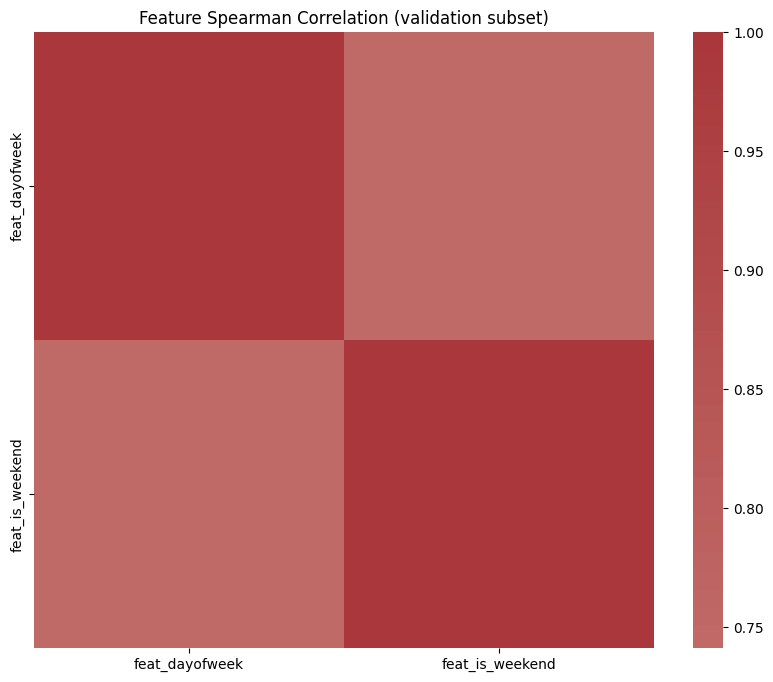

In [52]:
import seaborn as sns, matplotlib.pyplot as plt

# ใช้เฉพาะ numeric และสุ่มลดขนาดเพื่อความเร็ว
Xv_num = X_va_final.select_dtypes(include=[np.number])
Xv_s = Xv_num.sample(n=min(8000, len(Xv_num)), random_state=42)

corr = Xv_s.corr(method='spearman')
plt.figure(figsize=(10,8))
sns.heatmap(corr.clip(-1,1), cmap='vlag', center=0)
plt.title('Feature Spearman Correlation (validation subset)')
plt.show()